Tabela de Resultados:
Strike (K) Preço (σ=10%) Preço (σ=30%) Preço de Mercado Vol. Implícita
       $30       $9.8758       $9.9298          $9.8974         26.12%
       $35       $4.9400       $5.5036          $5.1655         22.18%
       $40       $0.7879       $2.3617          $1.4174         17.99%
       $45       $0.0065       $0.7741          $0.3135         21.55%
       $50       $0.0000       $0.1993          $0.0797         24.89%


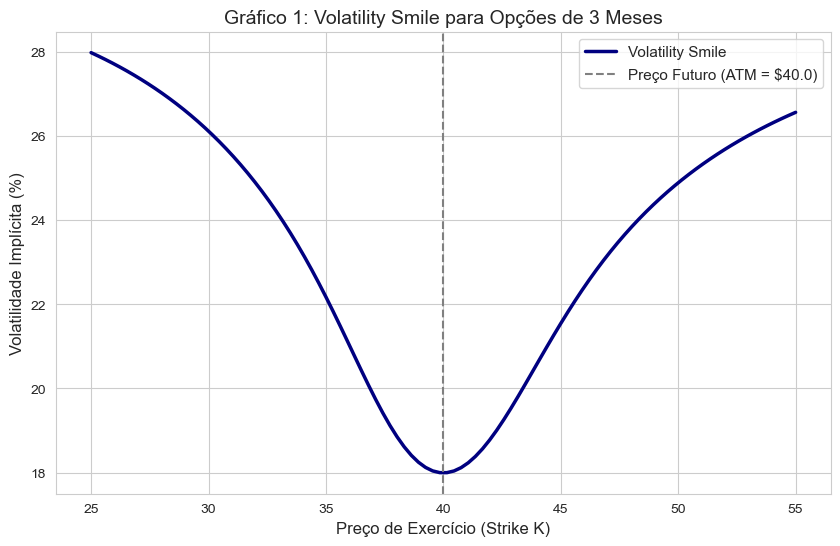

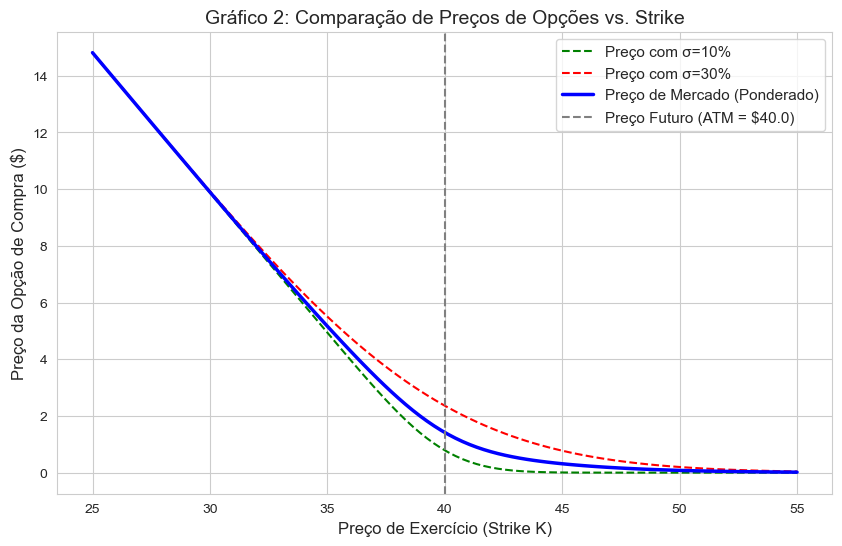

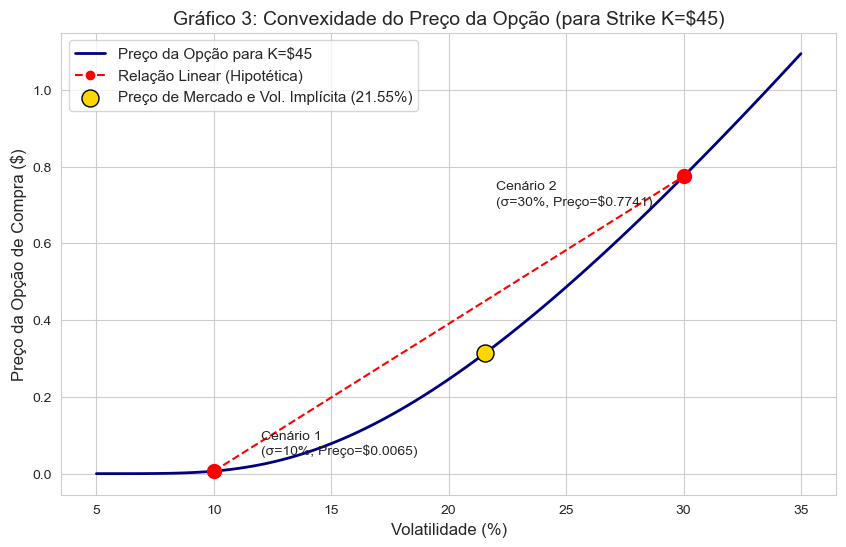

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Funções Principais ---

def black_76_call(F, K, T, r, sigma):
    """
    Calcula o preço de uma opção de compra europeia sobre futuros (modelo Black-76).
    """
    # Evita divisão por zero ou log de zero se sigma for muito baixo
    if sigma < 1e-6:
        return np.maximum(0, F - K) * np.exp(-r * T)

    d1 = (np.log(F / K) + (sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return price

def implied_volatility(market_price, F, K, T, r):
    """
    Calcula a volatilidade implícita usando o solver Brentq.
    """
    # Função objetivo: a diferença entre o preço do modelo e o preço de mercado
    def objective_function(sigma):
        return black_76_call(F, K, T, r, sigma) - market_price

    # Tenta encontrar a volatilidade no intervalo [0.1%, 500%]
    try:
        iv = brentq(objective_function, 1e-3, 5.0)
    except ValueError:
        # Se não encontrar solução (ex: preço fora dos limites teóricos)
        iv = np.nan
    return iv

# --- 2. Parâmetros do Problema e Cálculo ---

# Parâmetros fornecidos no problema
F0 = 40.0         # Preço do futuro
r = 0.05          # Taxa de juros livre de risco
T = 0.25          # Vencimento em anos (3 meses)
sigma1 = 0.10     # Cenário de volatilidade 1
p1 = 0.60         # Probabilidade do cenário 1
sigma2 = 0.30     # Cenário de volatilidade 2
p2 = 0.40         # Probabilidade do cenário 2

# Faixa de preços de exercício (strikes) para gerar os gráficos
strike_range = np.linspace(25, 55, 100)
implied_vols = []
market_prices = []
prices_low_vol = []
prices_high_vol = []

# Loop para calcular a volatilidade implícita para cada strike
for K in strike_range:
    # Calcula o preço da opção para cada cenário de volatilidade
    price1 = black_76_call(F0, K, T, r, sigma1)
    price2 = black_76_call(F0, K, T, r, sigma2)

    # Armazena os preços para o gráfico de comparação
    prices_low_vol.append(price1)
    prices_high_vol.append(price2)

    # Calcula o preço de mercado ponderado
    market_price = p1 * price1 + p2 * price2
    market_prices.append(market_price)

    # Calcula a volatilidade implícita para o preço de mercado
    iv = implied_volatility(market_price, F0, K, T, r)
    implied_vols.append(iv)

# --- Exibição da Tabela de Resultados (como no LaTeX) ---
strikes_tabela = [30, 35, 40, 45, 50]
dados_tabela = []
for k in strikes_tabela:
    c1 = black_76_call(F0, k, T, r, sigma1)
    c2 = black_76_call(F0, k, T, r, sigma2)
    cm = p1 * c1 + p2 * c2
    iv = implied_volatility(cm, F0, k, T, r)
    dados_tabela.append([f"${k}", f"${c1:.4f}", f"${c2:.4f}", f"${cm:.4f}", f"{iv*100:.2f}%"])

df = pd.DataFrame(dados_tabela, columns=["Strike (K)", "Preço (σ=10%)", "Preço (σ=30%)", "Preço de Mercado", "Vol. Implícita"])
print("Tabela de Resultados:")
print(df.to_string(index=False))


# --- 3. Geração de Gráficos ---

# Configurações de estilo para os gráficos
sns.set_style("whitegrid")
plt.rc('figure', figsize=(10, 6))
plt.rc('axes', titlesize=14, labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=11)

# GRÁFICO 1: A VOLATILITY SMILE
plt.figure()
plt.plot(strike_range, np.array(implied_vols) * 100, label='Volatility Smile', color='navy', lw=2.5)
plt.axvline(x=F0, color='grey', linestyle='--', label=f'Preço Futuro (ATM = ${F0})')
plt.title('Gráfico 1: Volatility Smile para Opções de 3 Meses')
plt.xlabel('Preço de Exercício (Strike K)')
plt.ylabel('Volatilidade Implícita (%)')
plt.legend()
plt.show()

# GRÁFICO 2: COMPARAÇÃO DE PREÇOS
plt.figure()
plt.plot(strike_range, prices_low_vol, label='Preço com σ=10%', linestyle='--', color='green')
plt.plot(strike_range, prices_high_vol, label='Preço com σ=30%', linestyle='--', color='red')
plt.plot(strike_range, market_prices, label='Preço de Mercado (Ponderado)', color='blue', lw=2.5)
plt.axvline(x=F0, color='grey', linestyle='--', label=f'Preço Futuro (ATM = ${F0})')
plt.title('Gráfico 2: Comparação de Preços de Opções vs. Strike')
plt.xlabel('Preço de Exercício (Strike K)')
plt.ylabel('Preço da Opção de Compra ($)')
plt.legend()
plt.show()

# GRÁFICO 3: DEMONSTRAÇÃO DA CONVEXIDADE
K_demo = 45 # Escolhe um strike OTM para demonstrar o efeito
vol_range = np.linspace(0.05, 0.35, 100)
price_at_vols = [black_76_call(F0, K_demo, T, r, v) for v in vol_range]

# Preços nos cenários específicos
price1_demo = black_76_call(F0, K_demo, T, r, sigma1)
price2_demo = black_76_call(F0, K_demo, T, r, sigma2)
# Preço de mercado ponderado
market_price_demo = p1 * price1_demo + p2 * price2_demo
# Volatilidade implicita para este strike
iv_demo = implied_volatility(market_price_demo, F0, K_demo, T, r)

plt.figure()
# Curva convexa de preço vs. volatilidade
plt.plot(vol_range * 100, price_at_vols, label=f'Preço da Opção para K=${K_demo}', color='navy', lw=2)
# Linha pontilhada mostrando a média ponderada (comportamento linear)
plt.plot([sigma1*100, sigma2*100], [price1_demo, price2_demo], 'ro--', label='Relação Linear (Hipotética)')

# Pontos de interesse
plt.scatter([sigma1*100, sigma2*100], [price1_demo, price2_demo], color='red', s=100, zorder=5)
plt.scatter(iv_demo*100, market_price_demo, color='gold', edgecolor='black', s=150, zorder=5, label=f'Preço de Mercado e Vol. Implícita ({iv_demo*100:.2f}%)')

# Anotações
plt.annotate(f'Cenário 1\n(σ=10%, Preço=${price1_demo:.4f})', xy=(sigma1*100, price1_demo), xytext=(12, 0.05))
plt.annotate(f'Cenário 2\n(σ=30%, Preço=${price2_demo:.4f})', xy=(sigma2*100, price2_demo), xytext=(22, 0.7))

plt.title(f'Gráfico 3: Convexidade do Preço da Opção (para Strike K=${K_demo})')
plt.xlabel('Volatilidade (%)')
plt.ylabel('Preço da Opção de Compra ($)')
plt.legend()
plt.show()